# `e3nn` Tutorial: July 2, 2024

See `e3nn` original paper and github repo.

In [1]:
from e3nn import o3

In [2]:
import warnings

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`.")

### `Irrep` and `Irreps`

`Irrep` represents certain irreducible representation with rotational order $l$ and parity $p$ (either even or odd).  
`Irreps` contains direct sum of irreps.  

**Note.** `Irrep` itself does not contain any data: it consits of tuple of tuples and integers, if you take a look at the source code (`e3nn/e3nn/o3/_irreps.py`).

In [3]:
irreps = o3.Irreps("1x0e + 3x0o + 5x1o + 3x1e + 5x2o")
print(irreps)

1x0e+3x0o+5x1o+3x1e+5x2o


Each irrep in `Irreps` can be accessed by index.

In [4]:
for idx in range(5):
    print(irreps[idx])

1x0e
3x0o
5x1o
3x1e
5x2o


Further indexing: note that `irreps[0] = 1x0e`.

In [4]:
print(irreps[0][0])
print(irreps[0][1])

1
0e


$(l, p)$ pair

In [5]:
print(irreps[0][1][0])
print(irreps[0][1][1])

0
1


In [6]:
print(irreps[1][1][0])
print(irreps[1][1][1])

0
-1


# `TensorProduct`

Refer to **Section 7** in `e3nn` paper.

In [5]:
import torch

x1          = torch.tensor([1., 0., 0., 2., 1., 0.], dtype = torch.float32)
x2          = torch.tensor([-2.,        1., 0., 1.], dtype = torch.float32)

irreps_in1  = o3.Irreps('1x1o+1x1o')
irreps_in2  = o3.Irreps('1x0e+1x1o')
irreps_out  = o3.Irreps('1x0e+1x1o')

`FullyConnectedTensorProduct` (simplified version of `TensorProduct`) connects all possible paths.

tensor([ 0.6444, -1.7535, -1.4124,  0.0000], grad_fn=<ViewBackward0>)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

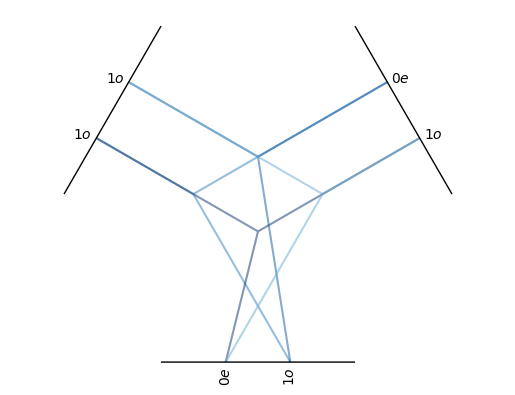

In [14]:
tp          = o3.FullyConnectedTensorProduct(irreps_in1, irreps_in2, irreps_out)
out         = tp(x1, x2)
print(out)
tp.visualize()

In [9]:
tp.instructions

[Instruction(i_in1=0, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.224744871391589, path_shape=(1, 1, 1)),
 Instruction(i_in1=0, i_in2=1, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 1)),
 Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.224744871391589, path_shape=(1, 1, 1)),
 Instruction(i_in1=1, i_in2=1, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 1))]

### `TensorProduct` example usage

Each `instruction` combines `in1[i_1]` and `in2[i_2]` to yield `out[i_out]`, in `Irreps` convention.  

[0] Above example with `TensorProduct`

tensor([1.0503, 1.7531, 0.4218, 0.0000], grad_fn=<ViewBackward0>)
[Instruction(i_in1=0, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.224744871391589, path_shape=(1, 1, 1)), Instruction(i_in1=0, i_in2=1, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 1)), Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.224744871391589, path_shape=(1, 1, 1)), Instruction(i_in1=1, i_in2=1, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 1))]


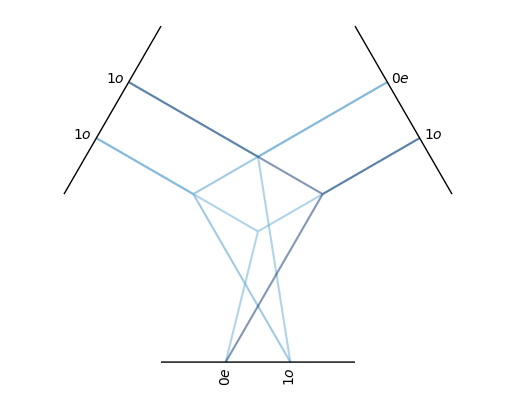

In [15]:
module = o3.TensorProduct(
    '1o + 1o',
    '0e + 1o',
    '0e + 1o',
    [
        (0, 0, 1, 'uvw', True), # 1o * 0e -> 1o
        (0, 1, 0, 'uvw', True), # 1o * 1o -> 0e
        (1, 0, 1, 'uvw', True), # 1o * 0e -> 1o
        (1, 1, 0, 'uvw', True), # 1o * 1o -> 0e
    ]
)

print(module(x1, x2))
module.visualize()
print(module.instructions)

[1] $\mathbf{z}_{u} = \mathbf{x}_{u} \wedge \mathbf{y}_{u}$

In [59]:
# [1] cross product of vectors with vectors, elementwise
# 1o \wedge 1o -> 1e

module = o3.TensorProduct(
    '16x1o',                    # irreps_in1
    '16x1o',                    # irreps_in2
    '16x1e',                    # irreps_out
    [
        (0, 0, 0, 'uuu', False) # instructions: (i_1, i_2, i_out, mode, train)
    ]
)

irreps_in1 = torch.nn.functional.one_hot(torch.arange(16)%3, 3).flatten().float()
irreps_in2 = torch.ones(16, 3).flatten().float()
irreps_out = module(irreps_in1, irreps_in2)
irreps_out.view(-1, 3)

tensor([[ 0.0000, -0.7071,  0.7071],
        [ 0.7071,  0.0000, -0.7071],
        [-0.7071,  0.7071,  0.0000],
        [ 0.0000, -0.7071,  0.7071],
        [ 0.7071,  0.0000, -0.7071],
        [-0.7071,  0.7071,  0.0000],
        [ 0.0000, -0.7071,  0.7071],
        [ 0.7071,  0.0000, -0.7071],
        [-0.7071,  0.7071,  0.0000],
        [ 0.0000, -0.7071,  0.7071],
        [ 0.7071,  0.0000, -0.7071],
        [-0.7071,  0.7071,  0.0000],
        [ 0.0000, -0.7071,  0.7071],
        [ 0.7071,  0.0000, -0.7071],
        [-0.7071,  0.7071,  0.0000],
        [ 0.0000, -0.7071,  0.7071]])

[2] $\mathbf{z}_{w} = \sum_{u,v}w_{uvw}\mathbf{x}_{u}\wedge\mathbf{y}_{v}$

In [60]:
module = o3.TensorProduct(
    '16x1o',
    '16x1o',
    '16x1e',
    [
        (0, 0, 0, 'uvw', True)
    ]
)

irreps_in1 = torch.nn.functional.one_hot(torch.arange(16)%3, 3).flatten().float()
irreps_in2 = torch.ones(16, 3).flatten().float()
irreps_out = module(irreps_in1, irreps_in2)
irreps_out.view(-1, 3)

tensor([[ 1.0190, -1.0961,  0.0771],
        [-0.3863,  0.6785, -0.2921],
        [ 0.9494, -0.1759, -0.7735],
        [-0.2743,  0.1343,  0.1401],
        [ 0.3086,  0.1807, -0.4892],
        [-0.0770,  0.9455, -0.8685],
        [ 0.5533, -0.6828,  0.1295],
        [ 0.0020, -0.2510,  0.2489],
        [ 0.8356, -0.2095, -0.6260],
        [-0.6107,  0.0377,  0.5730],
        [-0.1409, -0.8778,  1.0187],
        [-0.7978,  0.5390,  0.2588],
        [ 0.2486,  0.2237, -0.4723],
        [-0.0211,  0.3767, -0.3557],
        [-0.1389, -0.3499,  0.4888],
        [ 0.1959, -0.3481,  0.1522]], grad_fn=<ViewBackward0>)

[3] Custom input variance and custom path weight

In [61]:
module = o3.TensorProduct(
    '8x0o + 8x1o',
    '16x1o',
    '16x1e',
    [
        (0, 0, 0, 'uvw', True, 3),
        (1, 0, 0, 'uvw', True, 1),
    ],
    in2_var = [1/16]
)

[4] Dot product

In [62]:
irreps = o3.Irreps('3x0e + 4x0o + 1x1e + 1x2o + 1x3o')

module = o3.TensorProduct(
    irreps,
    irreps,
    '1x0e',
    [
        (i, i, 0, 'uuw', False) for i, (_, _) in enumerate(irreps)
    ]
)

[5] $\mathbf{z}_{u} = \mathbf{x}_{u} \otimes \sum_{v} w_{uv} \mathbf{y}_{v}$

[Instruction(i_in1=0, i_in2=0, i_out=0, connection_mode='uvu', has_weight=True, path_weight=0.31622776601683794, path_shape=(8, 10)), Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvu', has_weight=True, path_weight=0.31622776601683794, path_shape=(7, 10)), Instruction(i_in1=1, i_in2=1, i_out=1, connection_mode='uvu', has_weight=True, path_weight=0.31622776601683794, path_shape=(7, 10)), Instruction(i_in1=1, i_in2=2, i_out=1, connection_mode='uvu', has_weight=True, path_weight=0.31622776601683794, path_shape=(7, 10)), Instruction(i_in1=2, i_in2=0, i_out=2, connection_mode='uvu', has_weight=True, path_weight=0.408248290463863, path_shape=(3, 10)), Instruction(i_in1=2, i_in2=1, i_out=2, connection_mode='uvu', has_weight=True, path_weight=0.408248290463863, path_shape=(3, 10)), Instruction(i_in1=2, i_in2=2, i_out=2, connection_mode='uvu', has_weight=True, path_weight=0.408248290463863, path_shape=(3, 10))]


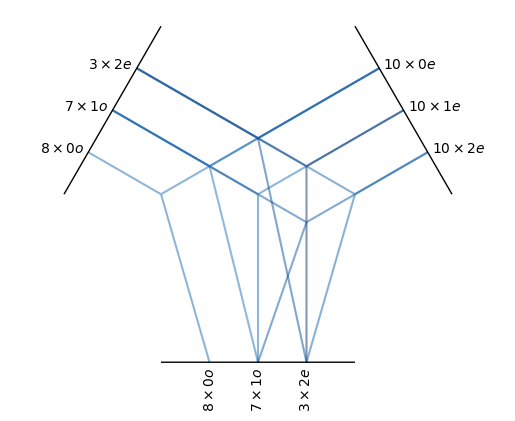

In [63]:
module = o3.TensorProduct(
    '8x0o + 7x1o + 3x2e',
    '10x0e + 10x1e + 10x2e',
    '8x0o + 7x1o + 3x2e',
    [
        # l = 0 output
        (0, 0, 0, 'uvu', True),
        # (1, 1, 0, 'uvw', True),
        # l = 1 output
        # Error: (0, 1, 1, 'uvu', True),
        (1, 0, 1, 'uvu', True),
        (1, 1, 1, 'uvu', True),
        (1, 2, 1, 'uvu', True),
        # l = 2 output
        (2, 0, 2, 'uvu', True),
        (2, 1, 2, 'uvu', True),
        (2, 2, 2, 'uvu', True)
    ]
)
module.visualize()

print(module.instructions)

In [64]:
r = o3.ReducedTensorProducts('ijkl=jikl=ijlk=klij', i = '1o')
print(r.irreps_out)

2x0e+2x2e+1x4e
